In [1]:
import h5py
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

'''
f = h5py.File('group_2024-11-06_08-02-46.touch')

data_size = list(f.keys())

print(f["Test"].values()) # Print number of members in a group

print(list(f["Test"].keys()))

image = cv2.imread("Image", np.asarray(f["Test"]["image_000400_cv2"])) # Show one of the image 

#print(np.asarray(f["Thumb"]["image_000085_cv2"]))

plt.imshow(image)
plt.show()

'''

'\nf = h5py.File(\'group_2024-11-06_08-02-46.touch\')\n\ndata_size = list(f.keys())\n\nprint(f["Test"].values()) # Print number of members in a group\n\nprint(list(f["Test"].keys()))\n\nimage = cv2.imread("Image", np.asarray(f["Test"]["image_000400_cv2"])) # Show one of the image \n\n#print(np.asarray(f["Thumb"]["image_000085_cv2"]))\n\nplt.imshow(image)\nplt.show()\n\n'

[ WARN:0@23.538] global loadsave.cpp:241 findDecoder imread_('Average'): can't open/read file: check file path/integrity
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


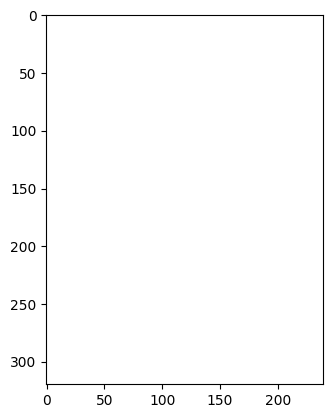

In [3]:
dataset = list(f["Test"].keys())

""" 
  Calculating the average frame intensity at each pixel

"""

frame_intensity = [np.stack(np.asarray(f["Test"][i]), axis=0) for i in dataset[:]]

average_frame_intensity = np.average(frame_intensity, axis=0)
average_frame_intensity = average_frame_intensity.astype(np.float64)

#print(average_frame_intensity)

plt.imshow(cv2.imread("Average", average_frame_intensity))
plt.show()


[ WARN:0@27.167] global loadsave.cpp:241 findDecoder imread_('Substract'): can't open/read file: check file path/integrity


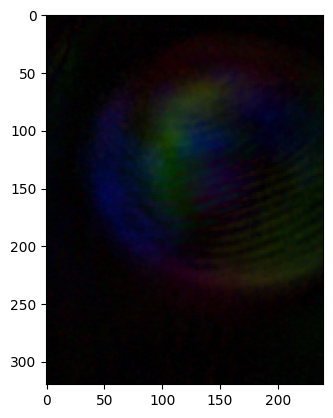

In [4]:
""" 
    Substracking the average intesity frame from each frame
"""

image_float = image.astype(np.float32)

substracted_image = np.abs(image_float - average_frame_intensity).astype(np.uint8)

plt.imshow(cv2.imread("Substract", substracted_image))
plt.show()

[ WARN:0@13520.734] global loadsave.cpp:241 findDecoder imread_('original_image'): can't open/read file: check file path/integrity
[ WARN:0@13520.739] global loadsave.cpp:241 findDecoder imread_('surface_normal_image'): can't open/read file: check file path/integrity
[ WARN:0@13520.740] global loadsave.cpp:241 findDecoder imread_('intensity_image'): can't open/read file: check file path/integrity


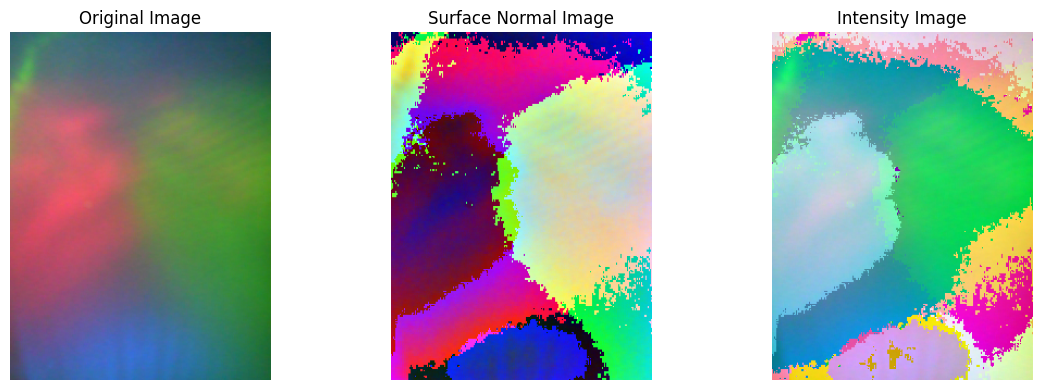

In [ ]:
random_number = random.choice(dataset)
random_image = np.asarray(f["Test"][random_number])

rgb_location = np.array([
    [0, 0.01732, 0.01], # R
    [0, -0.01732, 0.01], # G
    [0, 0, -0.02] # B
])

plane_original_locations = np.array([0.005, 0, 0.015])

rgb_direction_vector = np.array(rgb_location - plane_original_locations)
magnitudes = np.linalg.norm(rgb_direction_vector, axis=1)
unit_directions = rgb_direction_vector / magnitudes[:, np.newaxis]


def calculate_surface_normals(image, directions):
    """ 
        I = L*N
        N = S^-1 * I
        n = N / ||N||
    """
    surface_normal = np.zeros_like(image)

    for row in range(image.shape[0]):
        for col in range(image.shape[1]):
            pixel = image[row, col]
            normal_vector = np.matmul(np.linalg.inv(directions), pixel)
            surface_normal[row, col] = normal_vector
    
    return surface_normal

""" 
    1. Create zero matrix 
    2. Iterate over the matrix
    3. Try to derive surface normals.
"""
            

def calculate_pixel_intensity(directions, surface_normal):
    intensity_image = np.zeros_like(surface_normal)

    for row in range(surface_normal.shape[0]):
        for col in range(surface_normal.shape[1]):
            normal_pixel = surface_normal[row, col]
            intensity_pixel = np.matmul(directions, normal_pixel)
            intensity_image[row, col] = intensity_pixel

    return intensity_image


surface_normal_image = calculate_surface_normals(random_image, unit_directions)
intensity_image = calculate_pixel_intensity(unit_directions, surface_normal_image)

images = [
    cv2.imread("original_image", random_image),   
    cv2.imread("surface_normal_image", surface_normal_image),  
    cv2.imread("intensity_image", intensity_image)    
]

titles = ["Original Image", "Surface Normal Image", "Intensity Image"]

fig = plt.figure(figsize=(12, 4))

for i, (image, title) in enumerate(zip(images, titles), start=1):
    ax = fig.add_subplot(1, 3, i)
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  
    ax.set_title(title)
    ax.axis("off")

plt.tight_layout()
plt.show()

[ WARN:0@6515.652] global loadsave.cpp:241 findDecoder imread_('sibal'): can't open/read file: check file path/integrity
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


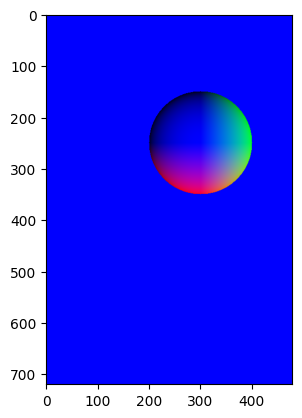

In [23]:
import math

zero_matrix = np.zeros((720, 480, 3))
center = (300, 250)
radius = 100
color = (255, 255, 255)

cv2.circle(zero_matrix, center, radius, color, thickness=-1)

def calculate_surface_normals(mask, center, radius, normals):
    # Iterate over the matrix, 
    for y in range(mask.shape[0]): # height of matrix
        for x in range(mask.shape[1]): # width of matrix
            # If values is masked, set surface normal to [0., 0., 1.]
            normals[y, x] = [0., 0., 1.]

            if np.sum(mask[y, x] > 0):
                
                """
                    d = (x-x_0)^2 + (y-y_0)^2
                    theta = the polar angle
                    phi = the azimuthal angle
                """
                d = math.sqrt(math.pow(x - center[0], 2) + math.pow(y - center[1], 2))
                theta = math.acos(d / radius)
                phi = math.atan2(y - center[1], x - center[0])

                theta = math.pi / 2 - theta

                nx = math.sin(theta) * math.sin(phi)
                ny = math.cos(phi) * math.sin(theta)
                nz = math.cos(theta)

                normals[y, x] = [nx, ny, nz]
    
    return normals

surface_normals_matrix = np.zeros((720, 480, 3))
sphere_center = [300, 250]

surface_normals = calculate_surface_normals(zero_matrix, sphere_center, radius, surface_normals_matrix)

plt.imshow(cv2.imread("sibal", surface_normals))
plt.show()